<a href="https://colab.research.google.com/github/sayakpaul/Image-Adversaries-101/blob/master/GANs_w_Adversaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import TensorFlow as verify the version
import tensorflow as tf
print(tf.__version__)

In [2]:
# Which GPU?
!nvidia-smi

Tue Apr 14 13:40:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from imutils import build_montages
from sklearn.utils import shuffle 
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [3]:
# Load data
((X_train, _), (X_test, _)) = tf.keras.datasets.fashion_mnist.load_data()
X_train.shape, X_test.shape

4423680/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28))

In [0]:
# Add a channel dimension so that it is compatible with Conv2D
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [0]:
# Combine the train and test images and scale the the image pixel values to [-1, 1]
trainImages = np.concatenate([X_train, X_test])
trainImages = (trainImages.astype("float") - 127.5) / 127.5

In [0]:
# Define the Hyperparameters
latent_dim = 100
height = 28
width = 28
nb_channels = 1

In [0]:
# Generator
def generator_network():
    generator = Sequential()
    inputShape = (7, 7, 64)
    chanDim = -1

    generator.add(Dense(input_dim=latent_dim, units=512))
    generator.add(LeakyReLU())
    generator.add(BatchNormalization())

    generator.add(Dense(7 * 7 * 64))
    generator.add(LeakyReLU())
    generator.add(BatchNormalization())

    generator.add(Reshape(inputShape))
    generator.add(Conv2DTranspose(32, (5, 5), strides=(2, 2),
        padding="same"))
    generator.add((LeakyReLU()))
    generator.add(BatchNormalization(axis=chanDim))

    generator.add(Conv2DTranspose(nb_channels, (5, 5), strides=(2, 2),
        padding="same", activation="tanh"))

    return generator

In [18]:
# Instantiate the Generator network
generator = generator_network()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               51712     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dense_5 (Dense)              (None, 3136)              1608768   
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 3136)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 3136)              12544     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)         

In [0]:
# Discriminator
def disc_network():
    disc = Sequential()
    inputShape = (height, width, nb_channels)

    disc.add(Conv2D(32, (5, 5), padding="same", strides=(2, 2),
        input_shape=inputShape))
    disc.add(LeakyReLU(alpha=0.2))

    disc.add(Conv2D(64, (5, 5), padding="same", strides=(2, 2)))
    disc.add(LeakyReLU(alpha=0.2))

    disc.add(Flatten())
    disc.add(Dense(512))
    disc.add(LeakyReLU(alpha=0.2))
    disc.add(Dropout(0.3))
    disc.add(Dense(1))
    disc.add(Activation("sigmoid"))
    
    return disc

In [19]:
# Instantiate the Discriminator network
disc = disc_network()
disc.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1606144   
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 512)              

In [0]:
# Optimizer for the Disc
disc_opt = tf.keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
disc.compile(optimizer=disc_opt, loss="binary_crossentropy")

In [0]:
# GAN
disc.trainable = False
gan_input = Input(shape=(latent_dim, ))
gan_output = disc(generator(gan_input))
gan = Model(gan_input, gan_output)

gan_opt = tf.keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
gan.compile(loss="binary_crossentropy", optimizer=gan_opt)

In [22]:
# Summary of the GAN architecture
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         1727233   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 1658753   
Total params: 3,385,986
Trainable params: 1,719,873
Non-trainable params: 1,666,113
_________________________________________________________________


In [0]:
# More hyperparameters
epochs = 10000
batch_size = 20

In [25]:
start = 0
for epoch in tqdm(range(epochs)):
    # Sample random noise from a normal distribution
    benchmark_noise = np.random.normal(size=(batch_size, latent_dim))
    # Map this noise to images via the generator network
    generated_images = generator.predict(benchmark_noise)
    
    # Calculate where to stop the current epoch, segregate the current batch
    # of real images and combine them with the fake ones
    stop = start + batch_size
    real_images = trainImages[start:stop]
    combined_images = np.concatenate([generated_images, real_images])
    
    # 1 -> Fake images, 0 -> Real images
    # Add a bit of random noise to the labels
    labels = np.array(([1] * batch_size) + ([0] * batch_size)).astype("float")
    labels += 0.05 * np.random.random(labels.shape)
    
    # Shuffle the datapoints of the newly created dataset
    (combined_images, labels) = shuffle(combined_images, labels)
    
    # Train the discriminator on these new dataset
    d_loss = disc.train_on_batch(combined_images, labels)
    
    # Again sample random noise from a normal distribution &
    # set the labels to such that they resemble real images to fool
    # discriminator
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    fake_labels = np.array([0] * batch_size)
    
    # Train the GAN with this random noise and fake labels, but only
    # update the weights of generator
    a_loss = gan.train_on_batch(random_latent_vectors, fake_labels)
    
    # Set the next batch
    start += batch_size
    if start > len(trainImages) - batch_size:
        start = 0
    
    # Logging
    if epoch % 500 == 0:
        print(f"Step: {epoch} Disc Loss: {d_loss} Adv Loss: {a_loss}")
        images = ((generated_images * 127.5) + 127.5).astype("int")
        images = np.repeat(images, 3, axis=-1)
        vis = build_montages(images, (28, 28), (4, 5))[0]
        cv2.imwrite("vis" + str(epoch) + ".png", vis)

  0%|          | 4/10000 [00:08<15:32:40,  5.60s/it]

Step: 0 Disc Loss: 0.7264326214790344 Adv Loss: 0.16824400424957275


  5%|▌         | 505/10000 [00:26<05:59, 26.43it/s]

Step: 500 Disc Loss: 0.6675554513931274 Adv Loss: 1.6335111856460571


 10%|█         | 1006/10000 [00:45<05:42, 26.26it/s]

Step: 1000 Disc Loss: 0.4600725769996643 Adv Loss: 1.180761456489563


 15%|█▌        | 1504/10000 [01:04<05:27, 25.93it/s]

Step: 1500 Disc Loss: 0.37954431772232056 Adv Loss: 1.4102908372879028


 20%|██        | 2005/10000 [01:23<05:02, 26.45it/s]

Step: 2000 Disc Loss: 0.5361297130584717 Adv Loss: 2.2946715354919434


 25%|██▌       | 2503/10000 [01:42<05:14, 23.87it/s]

Step: 2500 Disc Loss: 0.4684022068977356 Adv Loss: 2.108780860900879


 30%|███       | 3004/10000 [02:01<04:23, 26.58it/s]

Step: 3000 Disc Loss: 0.33347785472869873 Adv Loss: 2.1794848442077637


 35%|███▌      | 3505/10000 [02:20<04:00, 27.06it/s]

Step: 3500 Disc Loss: 0.3128819167613983 Adv Loss: 2.511215925216675


 40%|████      | 4006/10000 [02:40<03:54, 25.52it/s]

Step: 4000 Disc Loss: 0.3326495587825775 Adv Loss: 1.757765769958496


 45%|████▌     | 4504/10000 [02:59<03:25, 26.76it/s]

Step: 4500 Disc Loss: 0.4337260127067566 Adv Loss: 1.7907596826553345


 50%|█████     | 5005/10000 [03:18<03:12, 25.96it/s]

Step: 5000 Disc Loss: 0.28850388526916504 Adv Loss: 1.5960016250610352


 55%|█████▌    | 5506/10000 [03:37<02:46, 26.94it/s]

Step: 5500 Disc Loss: 0.4472404420375824 Adv Loss: 1.688951849937439


 60%|██████    | 6004/10000 [03:56<02:25, 27.54it/s]

Step: 6000 Disc Loss: 0.2737448215484619 Adv Loss: 2.5686511993408203


 65%|██████▌   | 6505/10000 [04:15<02:15, 25.83it/s]

Step: 6500 Disc Loss: 0.43683165311813354 Adv Loss: 2.346729278564453


 70%|███████   | 7006/10000 [04:34<01:49, 27.32it/s]

Step: 7000 Disc Loss: 0.2780314087867737 Adv Loss: 1.9535291194915771


 75%|███████▌  | 7504/10000 [04:53<01:32, 26.94it/s]

Step: 7500 Disc Loss: 0.35587388277053833 Adv Loss: 2.101675271987915


 80%|████████  | 8005/10000 [05:12<01:16, 26.15it/s]

Step: 8000 Disc Loss: 0.44942203164100647 Adv Loss: 2.268673896789551


 85%|████████▌ | 8506/10000 [05:31<00:55, 26.89it/s]

Step: 8500 Disc Loss: 0.2834746837615967 Adv Loss: 1.730851173400879


 90%|█████████ | 9004/10000 [05:50<00:37, 26.51it/s]

Step: 9000 Disc Loss: 0.3421613574028015 Adv Loss: 1.6488679647445679


 95%|█████████▌| 9505/10000 [06:09<00:18, 26.14it/s]

Step: 9500 Disc Loss: 0.3749707341194153 Adv Loss: 1.6673446893692017


100%|██████████| 10000/10000 [06:28<00:00, 25.72it/s]


## Generate images using the trained generator from random noise

In [26]:
# Sample random noise from a normal distribution
benchmark_noise = np.random.normal(size=(batch_size, latent_dim))
# Map this noise to images via the generator network
generated_images = generator.predict(benchmark_noise)
# Scale back
images = ((generated_images * 127.5) + 127.5).astype("int")
images.shape

(20, 28, 28, 1)

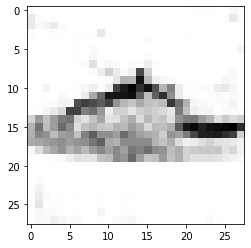

In [32]:
# How do the images look like?
random_idx = np.random.choice(images.shape[0], 1)
image_1 = images[random_idx].reshape(28, 28)
plt.imshow(image_1, cmap=plt.cm.binary)
plt.show()

## Forming adversarial examples

- Train a traditional image classifier
- Form examples

## Seeing if the adversarial examples are misclassified by the Discriminator of the GAN